<br>
<br>
<br>
<br>

# HACKATHON -

### New York / Maine Comparative Analysis and Predictive Modeling on Border Crossings from 1996-2019

<br>
<br>
<br>

#### SOURCE: Bureau of Transportation Statistics Border Crossing Entry Data

https://www.bts.gov/browse-statistical-products-and-data/border-crossing-data/border-crossingentry-data

<br>
<br>
<br>
<br>

### 1.01 Imports, Cleaning, and EDA.

In [124]:
#Imports:
import pandas as pd
import numpy as npa
import matplotlib.pyplot as plt
import sktime
import statsmodels
import pmdarima
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import EnsembleForecaster
import warnings
warnings.filterwarnings('ignore')
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [3]:
#Reading in csv:
df = pd.read_csv('./data/Border_Crossing_Entry_Data - Border_Crossing_Entry_Data.csv')

In [4]:
#Checking for nulls:
df.isnull().sum()

Port Name    0
State        0
Port Code    0
Border       0
Year         0
Date         0
Measure      0
Value        0
Location     0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346733 entries, 0 to 346732
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Port Name  346733 non-null  object
 1   State      346733 non-null  object
 2   Port Code  346733 non-null  int64 
 3   Border     346733 non-null  object
 4   Year       346733 non-null  int64 
 5   Date       346733 non-null  object
 6   Measure    346733 non-null  object
 7   Value      346733 non-null  object
 8   Location   346733 non-null  object
dtypes: int64(2), object(7)
memory usage: 23.8+ MB


In [6]:
#Checking count of entries by year:
df['Year'].value_counts()

2010    16200
2006    16128
2005    16128
2007    16056
2008    16056
2009    16056
2004    15984
2015    15984
2012    15840
2011    15840
2013    15840
2014    15840
2003    15588
2001    14832
1996    14832
2002    14832
2000    14832
1999    14832
1998    14832
1997    14832
2016    13754
2017     9717
2018     9534
2019     2364
Name: Year, dtype: int64

In [7]:
#Checking count of entries by state:
df['State'].value_counts()

North Dakota    57071
Washington      44677
Montana         38154
Maine           38136
Texas           35754
Minnesota       23135
New York        20697
Arizona         19252
California      19102
Vermont         16247
Alaska          11529
Michigan         9985
Idaho            6551
New Mexico       6438
Ohio                5
Name: State, dtype: int64

In [8]:
#Filtering df to include only Maine and New York Personal Vehicle Passenger data:
df_ne = df.loc[df['State'].isin(['New York', 'Maine'])]
df_pvp = df_ne[df_ne['Measure'] == 'Personal Vehicle Passengers']
df_pv = df_ne[df_ne['Measure'] == 'Personal Vehicles']
df_t = df_ne[df_ne['Measure'] == 'Trucks']

#Convert Value column to integers:
df_pvp['Value'] = [int(i.replace(',','')) for i in df_pvp['Value']]
df_pv['Value'] = [int(i.replace(',','')) for i in df_pv['Value']]
df_t['Value'] = [int(i.replace(',','')) for i in df_t['Value']]

#Creating a Month column:
df_pvp['Month'] = [int(i.split('/')[0]) for i in df_pvp['Date']]
df_pv['Month'] = [int(i.split('/')[0]) for i in df_pv['Date']]
df_t['Month'] = [int(i.split('/')[0]) for i in df_t['Date']]

/var/folders/pc/tprsyq657ml755g4m3r5n18h0000gn/T/ipykernel_47663/3531145814.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pvp['Value'] = [int(i.replace(',','')) for i in df_pvp['Value']]
/var/folders/pc/tprsyq657ml755g4m3r5n18h0000gn/T/ipykernel_47663/3531145814.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pv['Value'] = [int(i.replace(',','')) for i in df_pv['Value']]
/var/folders/pc/tprsyq657ml755g4m3r5n18h0000gn/T/ipykernel_47663/3531145814.py:10: SettingWithCopyWarning: 
A value is try

In [9]:
#Saving cleaned Passenger Vehicle Passengers in NY and ME df to csv:
df_pvp.to_csv('./data/pvp_1996_2019.csv')

In [10]:
#Checking count of entries for each state:
df_pvp['State'].value_counts()

Maine       3301
New York    1782
Name: State, dtype: int64

In [11]:
#Checking names of ports of entry in New York:
df_pvp[df_pvp['State']=='New York']['Port Name'].value_counts()

Trout River               279
Massena                   279
Buffalo-Niagara Falls     279
Ogdensburg                279
Champlain-Rouses Point    279
Alexandria Bay            279
Cape Vincent              108
Name: Port Name, dtype: int64

In [12]:
#Checking names of ports of entry in Maine:
df_pvp[df_pvp['State']=='Maine']['Port Name'].value_counts()

Madawaska         279
Jackman           279
Fort Kent         279
Bridgewater       279
Houlton           279
Fort Fairfield    279
Calais            279
Limestone         279
Van Buren         279
Vanceboro         279
Portland          227
Eastport          195
Bar Harbor         89
Name: Port Name, dtype: int64

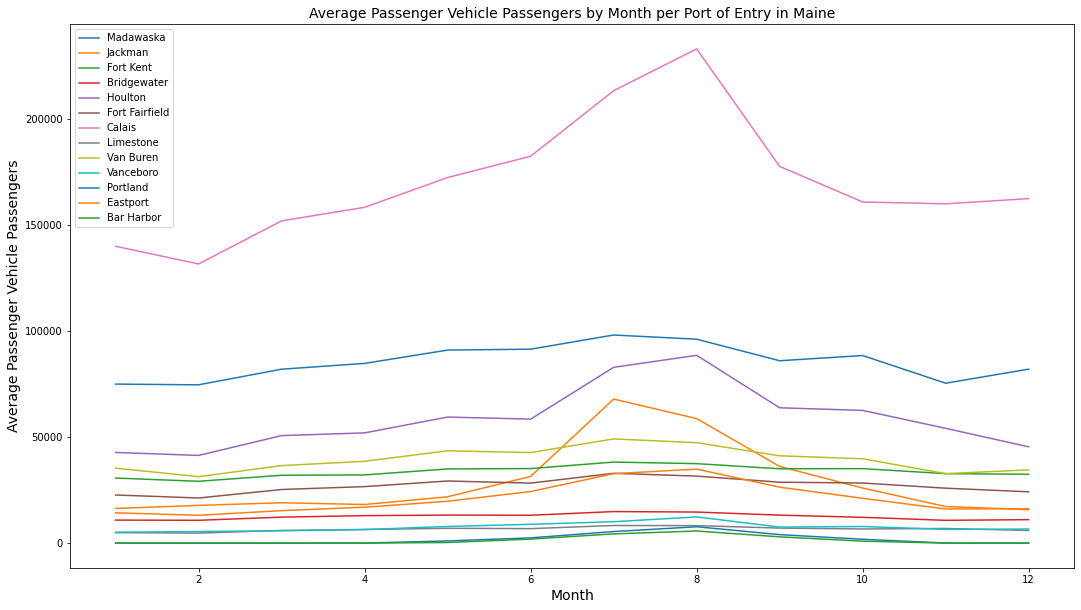

In [158]:
#Plot of Average Passenger Vehicle Passengers by Month per Port of Entry in Maine:
plt.figure(figsize=(18,10))
[plt.plot(df_pvp[df_pvp['Port Name'] == i].groupby('Month').mean().index, 
         df_pvp[df_pvp['Port Name'] == i].groupby('Month').mean()['Value'], label=i) 
        for i in list(df_pvp[df_pvp['State']=='Maine']['Port Name'].value_counts().index)];
plt.title('Average Passenger Vehicle Passengers by Month per Port of Entry in Maine', fontsize=14);
plt.xlabel('Month', fontsize=14);
plt.ylabel('Average Passenger Vehicle Passengers', fontsize=14);
plt.legend();
plt.savefig('./visualizations/me_avg_pvp_month.png', transparent=True, bbox_inches = 'tight')

- This plot shows that all of the US-Canada border entry points in Maine exhibit seasonal fluctuations in passenger vehicle passengers.

- Some show more intensified fluctiation than others, like Calais, Jackman, and Houlton.

- All of these regions have the highest intensity of passenger vehicle passengers in the summer, peaking around July and August. 

- This makes a lot of sense because these regions have very intense winters that can be prohibitive to travel.

- Also, Maine is often colloquially refered to as "Vacationland" and rightly so. Here, the correlation is most obvious as vacations peak in the summer.

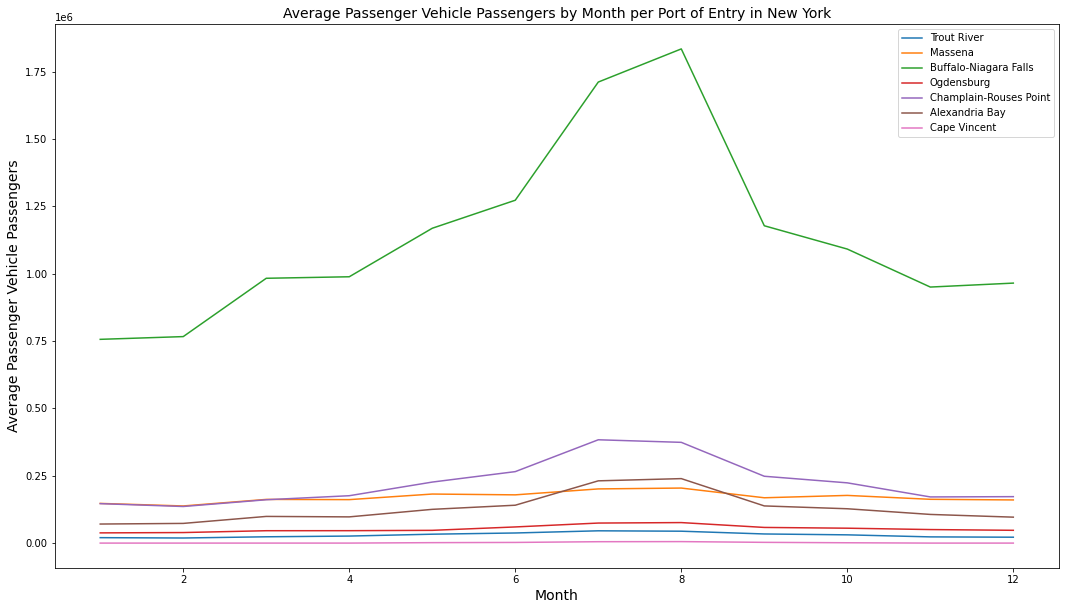

In [160]:
#Plot of Average Passenger Vehicle Passengers by Month per Port of Entry in New York
plt.figure(figsize=(18,10))
[plt.plot(df_pvp[df_pvp['Port Name'] == i].groupby('Month').mean().index, 
         df_pvp[df_pvp['Port Name'] == i].groupby('Month').mean()['Value'], label=i) 
        for i in list(df_pvp[df_pvp['State']=='New York']['Port Name'].value_counts().index)];
plt.title('Average Passenger Vehicle Passengers by Month per Port of Entry in New York', fontsize=14);
plt.xlabel('Month', fontsize=14);
plt.ylabel('Average Passenger Vehicle Passengers', fontsize=14);
plt.legend();
plt.savefig('./visualizations/ny_avg_pvp_month.png', transparent=True, bbox_inches = 'tight')

- This plot similarly shows that almost all of the US-Canada border entry points in New York exhibit seasonal fluctuations in passenger vehicle passengers.

- Some show more intensified fluctiation than others, like Buffalo-Niagara Falls, Champlain-Rouses Point, and Alexandria Bay.

- All of these regions have the highest intensity of passenger vehicle passengers in the summer, peaking around July and August. 

- This makes a lot of sense because these regions have very intense winters that can be prohibitive to travel.


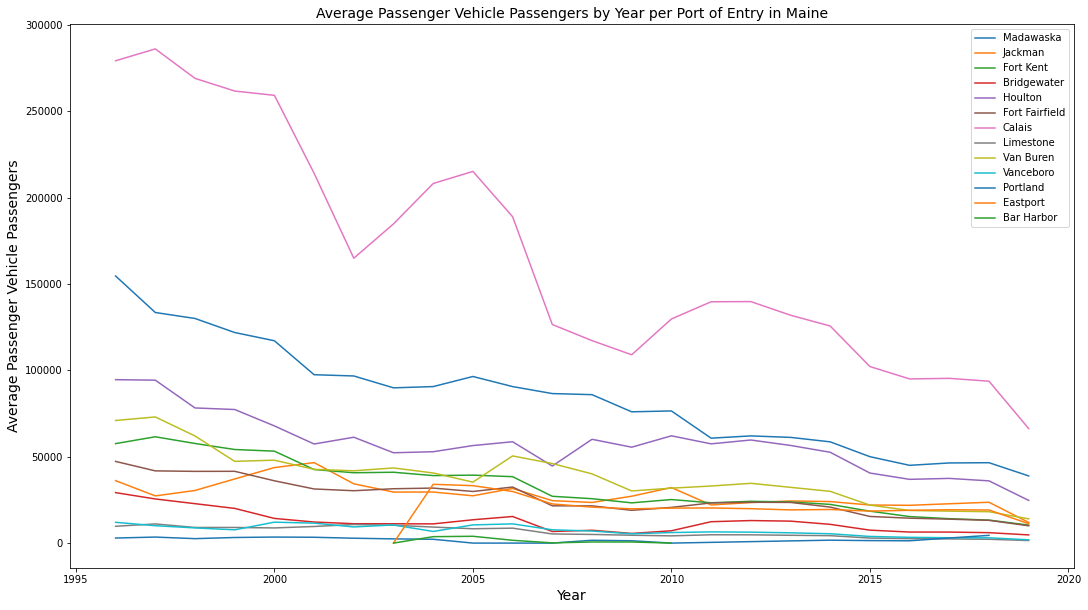

In [161]:
#Plot of Average Passenger Vehicle Passengers by Year per Port of Entry in Maine
plt.figure(figsize=(18,10))
[plt.plot(df_pvp[df_pvp['Port Name'] == i].groupby('Year').mean().index, 
         df_pvp[df_pvp['Port Name'] == i].groupby('Year').mean()['Value'], label=i) 
        for i in list(df_pvp[df_pvp['State']=='Maine']['Port Name'].value_counts().index)];
plt.title('Average Passenger Vehicle Passengers by Year per Port of Entry in Maine', fontsize=14);
plt.xlabel('Year', fontsize=14);
plt.ylabel('Average Passenger Vehicle Passengers', fontsize=14);
plt.legend();
plt.savefig('./visualizations/me_avg_pvp_year.png', transparent=True, bbox_inches = 'tight')

- This plot shows that almost all of the US-Canada border entry points in Maine have shown consistent decrease in passenger vehicle passengers over the past 25 years.

- This could perhaps be because of increasing affordability of air travel or increased cultural disinterest in road trips between the US and Canada.

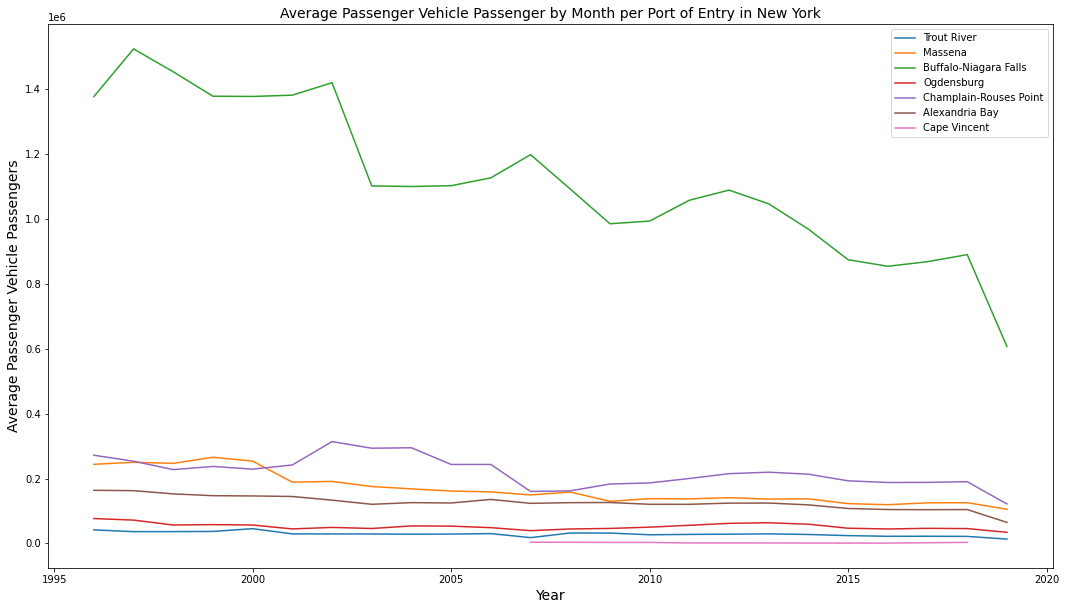

In [162]:
#Plot of Average Passenger Vehicle Passenger by Month per Port of Entry in New York
plt.figure(figsize=(18,10))
[plt.plot(df_pvp[df_pvp['Port Name'] == i].groupby('Year').mean().index, 
         df_pvp[df_pvp['Port Name'] == i].groupby('Year').mean()['Value'], label=i) 
        for i in list(df_pvp[df_pvp['State']=='New York']['Port Name'].value_counts().index)];
plt.title('Average Passenger Vehicle Passenger by Month per Port of Entry in New York', fontsize=14);
plt.xlabel('Year', fontsize=14);
plt.ylabel('Average Passenger Vehicle Passengers', fontsize=14);
plt.legend();
plt.savefig('./visualizations/ny_avg_pvp_year.png', transparent=True, bbox_inches = 'tight')

- This plot shows that almost all of the US-Canada border entry points in New York have shown consistent decrease in passenger vehicle passengers over the past 25 years.

- This could perhaps be because of increasing affordability of air travel or increased cultural disinterest in road trips between the US and Canada.

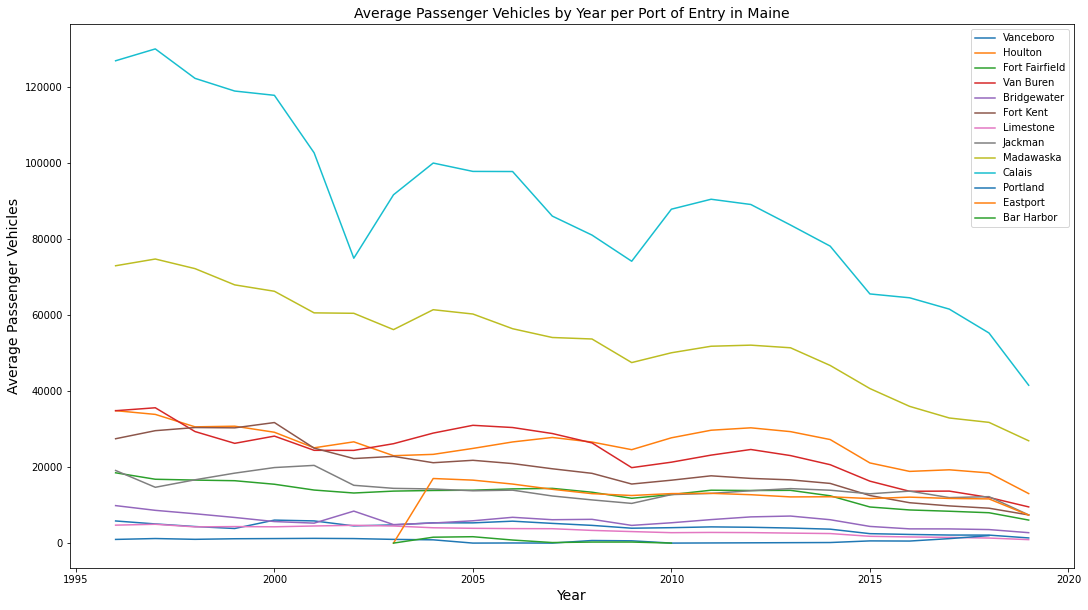

In [165]:
#Plot of 'Average Passenger Vehicles by Month per Port of Entry in Maine
plt.figure(figsize=(18,10))
[plt.plot(df_pv[df_pv['Port Name'] == i].groupby('Year').mean().index, 
         df_pv[df_pv['Port Name'] == i].groupby('Year').mean()['Value'], label=i) 
        for i in list(df_pv[df_pv['State']=='Maine']['Port Name'].value_counts().index)];
plt.title('Average Passenger Vehicles by Year per Port of Entry in Maine', fontsize=14);
plt.xlabel('Year', fontsize=14);
plt.ylabel('Average Passenger Vehicles', fontsize=14);
plt.legend();
plt.savefig('./visualizations/me_avg_pv_year.png', transparent=True, bbox_inches = 'tight')

- This plot shows similar decreases in just the number of passenger vehicles, proving that, for the most part, traffic is decreasing across the Maine-Canada border, not just carpooling. 

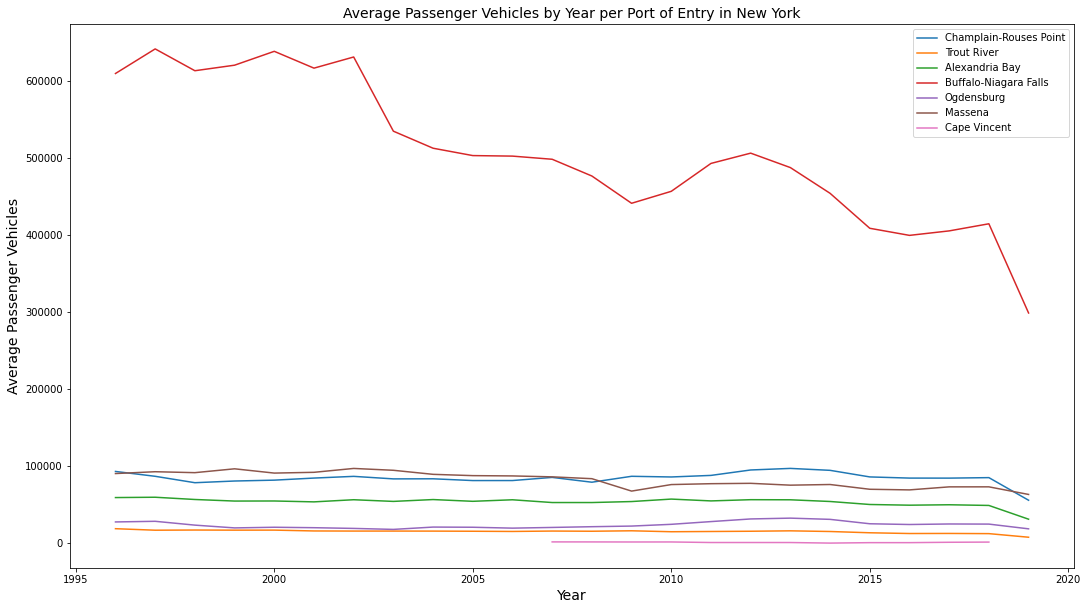

In [166]:
#Plot of Average Passenger Vehicles by Month per Port of Entry in New York
plt.figure(figsize=(18,10))
[plt.plot(df_pv[df_pv['Port Name'] == i].groupby('Year').mean().index, 
         df_pv[df_pv['Port Name'] == i].groupby('Year').mean()['Value'], label=i) 
        for i in list(df_pv[df_pv['State']=='New York']['Port Name'].value_counts().index)];
plt.title('Average Passenger Vehicles by Year per Port of Entry in New York', fontsize=14);
plt.xlabel('Year', fontsize=14);
plt.ylabel('Average Passenger Vehicles', fontsize=14);
plt.legend();
plt.savefig('./visualizations/ny_avg_pv_year.png', transparent=True, bbox_inches = 'tight')

-  This plot shows similar decreases in just the number of passenger vehicles, proving that, for the most part, traffic is decreasing across the New York-Canada border, not just carpooling. 

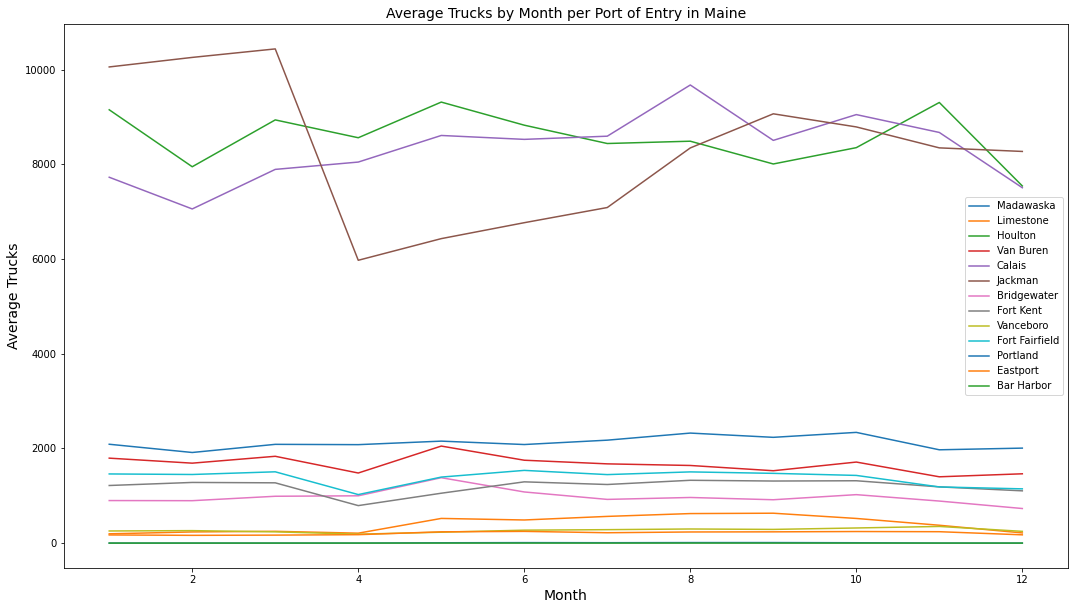

In [167]:
#Plot of Average Trucks by Month per Port of Entry in Maine
plt.figure(figsize=(18,10))
[plt.plot(df_t[df_t['Port Name'] == i].groupby('Month').mean().index, 
         df_t[df_t['Port Name'] == i].groupby('Month').mean()['Value'], label=i) 
        for i in list(df_t[df_t['State']=='Maine']['Port Name'].value_counts().index)];
plt.title('Average Trucks by Month per Port of Entry in Maine', fontsize=14);
plt.xlabel('Month', fontsize=14);
plt.ylabel('Average Trucks', fontsize=14);
plt.legend();
plt.savefig('./visualizations/me_avg_t_month.png', transparent=True, bbox_inches = 'tight')

- This plot shows that trucking across the border of Maine fluctuates much less seasonally than passenger vehicles and passenger vehicle passengers.

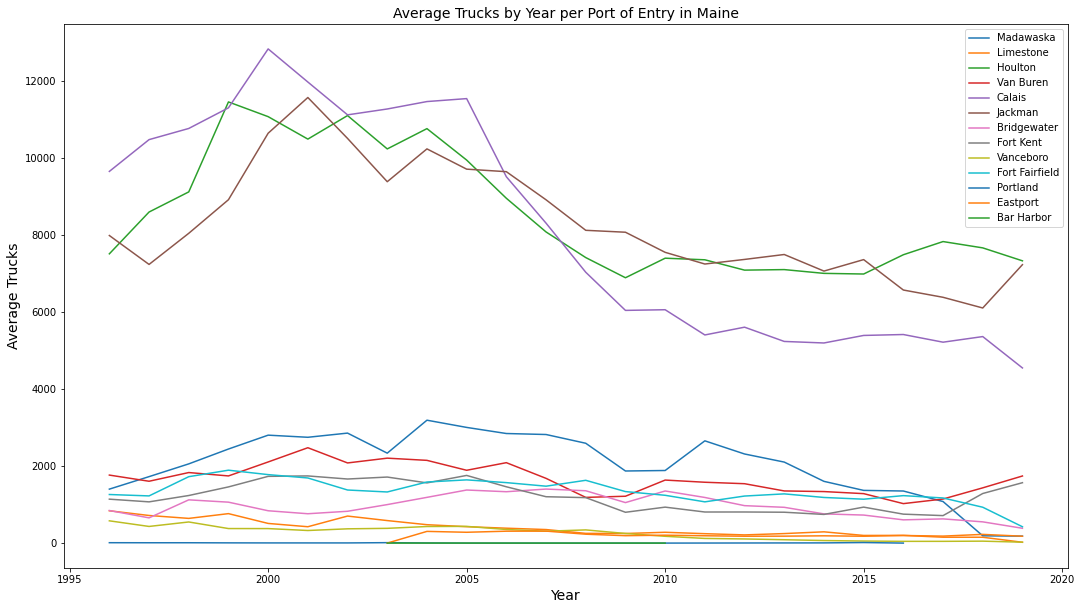

In [169]:
#Plot of Average Trucks by Month per Port of Entry in Maine
plt.figure(figsize=(18,10))
[plt.plot(df_t[df_t['Port Name'] == i].groupby('Year').mean().index, 
         df_t[df_t['Port Name'] == i].groupby('Year').mean()['Value'], label=i) 
        for i in list(df_t[df_t['State']=='Maine']['Port Name'].value_counts().index)];
plt.title('Average Trucks by Year per Port of Entry in Maine', fontsize=14);
plt.xlabel('Year', fontsize=14);
plt.ylabel('Average Trucks', fontsize=14);
plt.legend();
plt.savefig('./visualizations/me_avg_t_year.png', transparent=True, bbox_inches = 'tight')

- This plot shows that trucking across the border of Maine has generally decreased over the past 25 years, but less so as a trend and more so as a peak followed by a drop and then a leveling out. 

- The largest drop in cross border trucking activity in Maine occurs from 2005 to 2010.

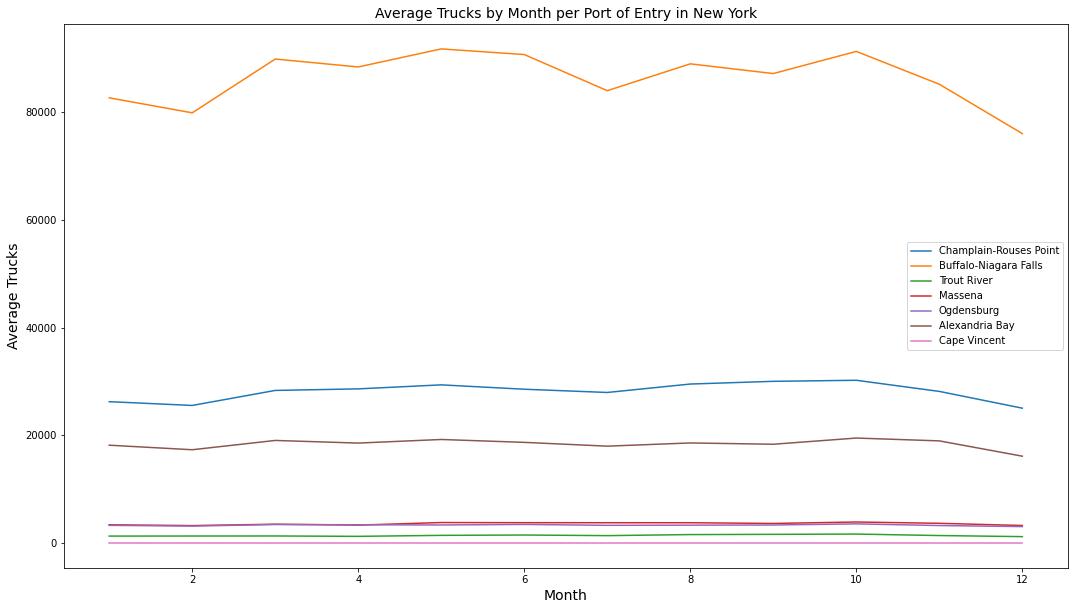

In [170]:
#Plot of Average Trucks by Month per Port of Entry in New York
plt.figure(figsize=(18,10))
[plt.plot(df_t[df_t['Port Name'] == i].groupby('Month').mean().index, 
         df_t[df_t['Port Name'] == i].groupby('Month').mean()['Value'], label=i) 
        for i in list(df_t[df_t['State']=='New York']['Port Name'].value_counts().index)];
plt.title('Average Trucks by Month per Port of Entry in New York', fontsize=14);
plt.xlabel('Month', fontsize=14);
plt.ylabel('Average Trucks', fontsize=14);
plt.legend();
plt.savefig('./visualizations/ny_avg_t_month.png', transparent=True, bbox_inches = 'tight')

- This plot shows that trucking across the border of New York fluctuates much less seasonally than passenger vehicles and passenger vehicle passengers.

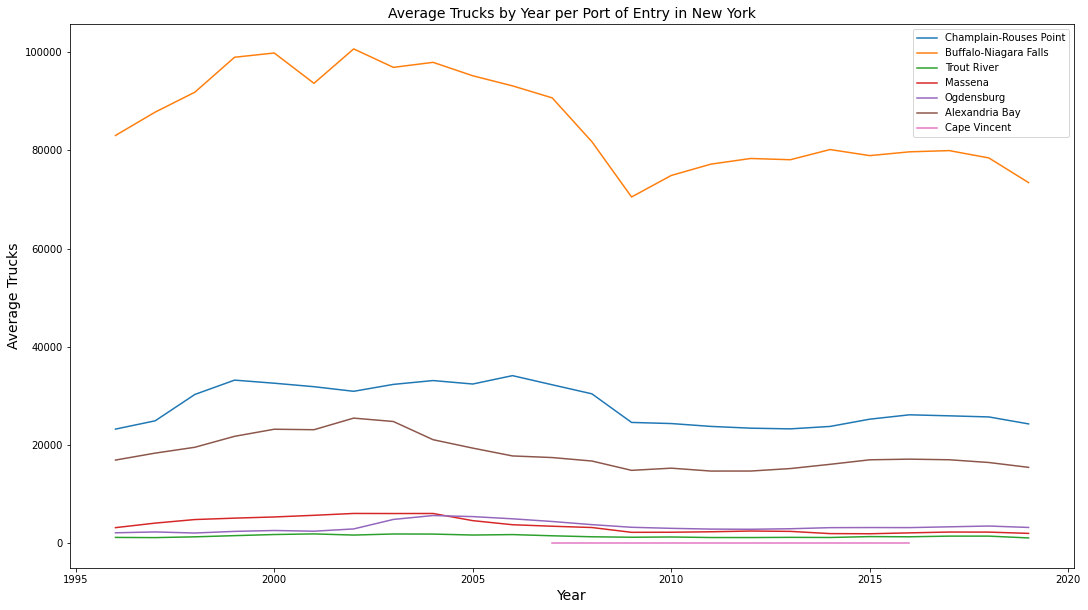

In [171]:
#Plot of Average Trucks by Year per Port of Entry in New York
plt.figure(figsize=(18,10))
[plt.plot(df_t[df_t['Port Name'] == i].groupby('Year').mean().index, 
         df_t[df_t['Port Name'] == i].groupby('Year').mean()['Value'], label=i) 
        for i in list(df_t[df_t['State']=='New York']['Port Name'].value_counts().index)];
plt.title('Average Trucks by Year per Port of Entry in New York', fontsize=14);
plt.xlabel('Year', fontsize=14);
plt.ylabel('Average Trucks', fontsize=14);
plt.legend();
plt.savefig('./visualizations/ny_avg_t_year.png', transparent=True, bbox_inches = 'tight')

- This plot shows that trucking across the border of New York has also generally decreased over the past 25 years, but less so as a trend and more so as a peak followed by a drop and then a leveling out. 

- The largest drop in cross border trucking activity in New York occurs generally from 2005 to 2008

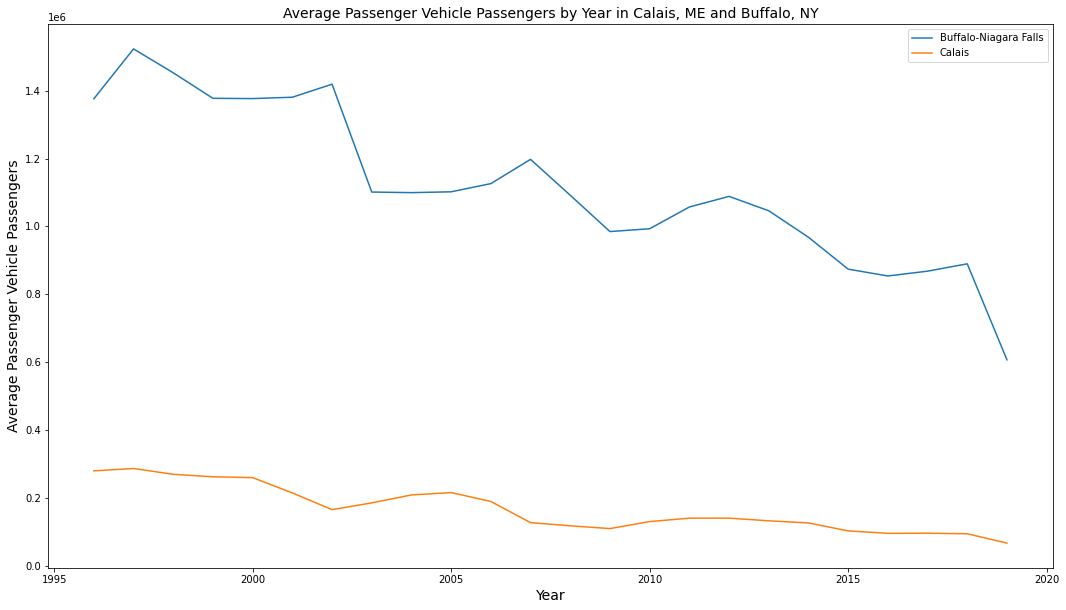

In [172]:
#Plot of Average Passenger Vehicle Passengers by Year in Calais, ME and Buffalo, NY
plt.figure(figsize=(18,10))
plt.plot(df_pvp[df_pvp['Port Name'] == 'Buffalo-Niagara Falls'].groupby('Year').mean().index, 
         df_pvp[df_pvp['Port Name'] == 'Buffalo-Niagara Falls'].groupby('Year').mean()['Value'], label='Buffalo-Niagara Falls')
plt.plot(df_pvp[df_pvp['Port Name'] == 'Calais'].groupby('Year').mean().index, 
         df_pvp[df_pvp['Port Name'] == 'Calais'].groupby('Year').mean()['Value'], label='Calais')
plt.title('Average Passenger Vehicle Passengers by Year in Calais, ME and Buffalo, NY', fontsize=14);
plt.xlabel('Year', fontsize=14);
plt.ylabel('Average Passenger Vehicle Passengers', fontsize=14);
plt.legend();
plt.savefig('./visualizations/me_ny_comb1.png', transparent=True, bbox_inches = 'tight')

- This plot isolates out the border entry point of each state with the highest activity in terms of trucking, passenger vehicles, and passenger vehicle passengers.

- These two points are Calais, Maine and Buffalo, New York.

- This plot shows that while Calais is an exceptionally busy border crossing point, it is nothing compared to that of Buffalo, NY

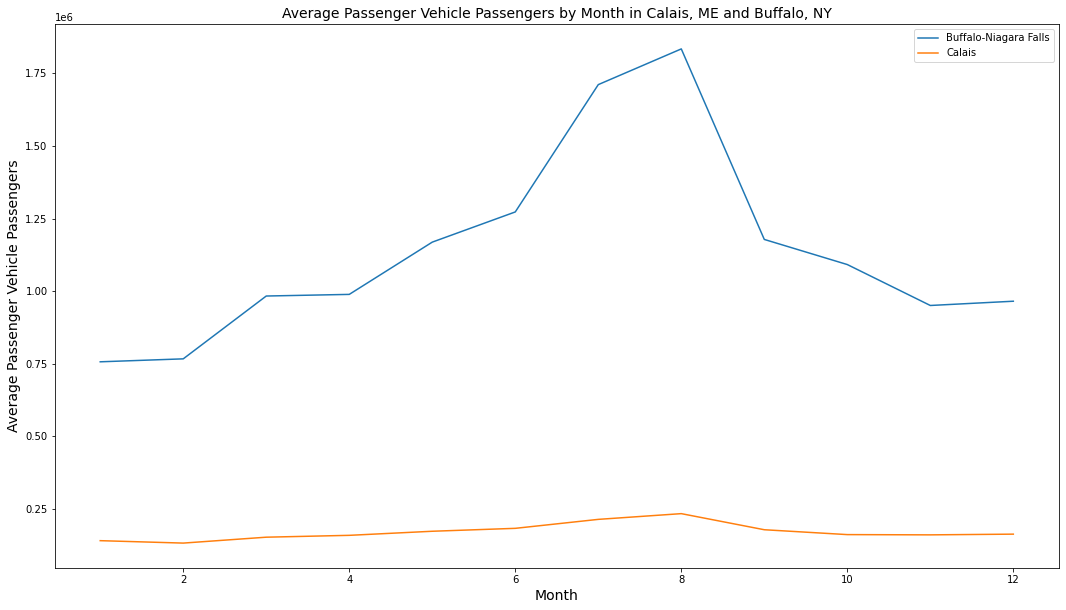

In [173]:
#Plot of Average Passenger Vehicle Passengers by Month in Calais, ME and Buffalo, NY
plt.figure(figsize=(18,10))
plt.plot(df_pvp[df_pvp['Port Name'] == 'Buffalo-Niagara Falls'].groupby('Month').mean().index, 
         df_pvp[df_pvp['Port Name'] == 'Buffalo-Niagara Falls'].groupby('Month').mean()['Value'], label='Buffalo-Niagara Falls')
plt.plot(df_pvp[df_pvp['Port Name'] == 'Calais'].groupby('Month').mean().index, 
         df_pvp[df_pvp['Port Name'] == 'Calais'].groupby('Month').mean()['Value'], label='Calais')
plt.title('Average Passenger Vehicle Passengers by Month in Calais, ME and Buffalo, NY', fontsize=14);
plt.xlabel('Month', fontsize=14);
plt.ylabel('Average Passenger Vehicle Passengers', fontsize=14);
plt.legend();
plt.savefig('./visualizations/me_ny_comb2.png', transparent=True, bbox_inches = 'tight')

- Again, this plot isolates out the border entry point of each state with the highest activity in terms of trucking, passenger vehicles, and passenger vehicle passengers.

- These two points are Calais, Maine and Buffalo, New York.

- This plot shows that while Calais is an exceptionally busy border crossing point, it is nothing compared to that of Buffalo, NY

<br>
<br>
<br>

#### 1.02 Reference Map.

![](map.png) 

<br>
<br>
<br>
<br>

### 2.01 Timeseries Modeling for Calais, ME Ports of Entry.

In [65]:
#Formatting Calais df for datetime forecasting:
df_cal = df_pvp[df_pvp['Port Name'] =='Calais']
df_cal = df_cal[['Port Name', 'Date', 'Value']]
df_cal['Date'] = pd.to_datetime(df_cal['Date'])
df_cal = df_cal.set_index('Date')
df_cal = df_cal.sort_index()

#Formatting Buffalo df for datetime forecasting:
df_buf = df_pvp[df_pvp['Port Name'] =='Buffalo-Niagara Falls']
df_buf = df_buf[['Port Name', 'Date', 'Value']]
df_buf['Date'] = pd.to_datetime(df_buf['Date'])
df_buf = df_buf.set_index('Date')
df_buf = df_buf.sort_index()

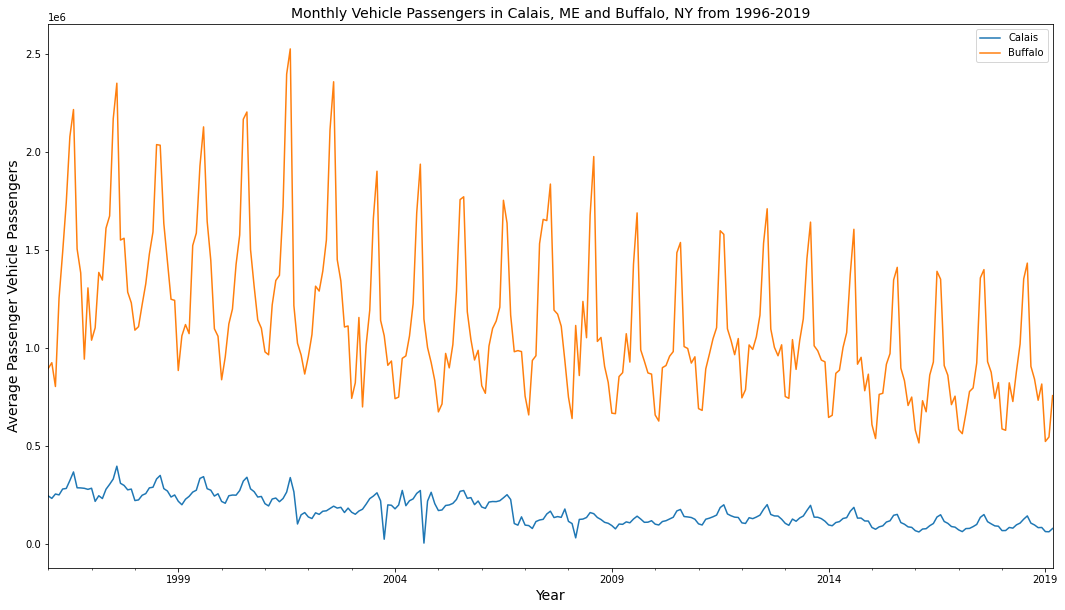

In [175]:
#Plot comparing Calais and Buffalo true monthly fluctiations of passenger vehicle passengers for the past 25 years.
plt.figure(figsize=(18,10))
df_cal['Value'].plot(label='Calais');
df_buf['Value'].plot(label='Buffalo');
plt.title('Monthly Vehicle Passengers in Calais, ME and Buffalo, NY from 1996-2019', fontsize=14);
plt.xlabel('Year', fontsize=14);
plt.ylabel('Average Passenger Vehicle Passengers', fontsize=14);
plt.legend();
plt.savefig('./visualizations/me_ny_comb3.png', transparent=True, bbox_inches = 'tight')

- This plot shows the shared seasonality of Calais and Buffalo in terms of passenger vehicle passenger fluctuations.

- This plot also points out the extreme differences in volume and fluctuation range between Calais and Buffalo.

In [69]:
#Correcting frequency and periodicity of dfs:
df_cal = df_cal.asfreq('MS')
df_cal.index = pd.PeriodIndex(df_cal.index, freq="M")
df_buf = df_buf.asfreq('MS')
df_buf.index = pd.PeriodIndex(df_buf.index, freq="M")

Mean Absolute Percentage Error: 0.48
Mean Squared Error: 62232.26


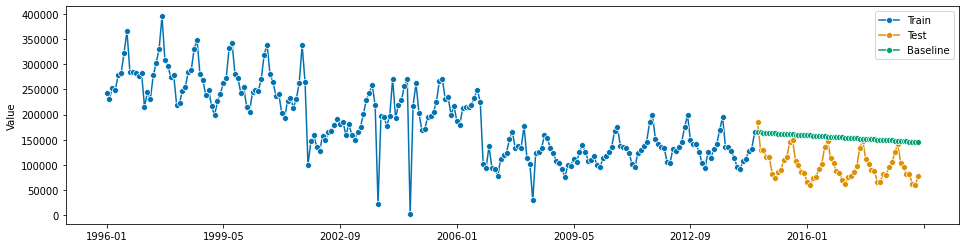

In [123]:
#Returning metrics and visualization of baseline performance:
y_cal = df_cal['Value']
y_train_cal, y_test_cal = temporal_train_test_split(y_cal, test_size=.2)
baseline_drift_cal = NaiveForecaster(strategy='drift')
baseline_drift_cal.fit(y_train_cal)
baseline_drift_preds_cal = baseline_drift_cal.predict(y_test_cal.index)
plot_series(y_train_cal, y_test_cal, baseline_drift_preds_cal,labels=['Train', 'Test', 'Baseline']);
print('Mean Absolute Percentage Error: ' + str(round(mean_absolute_percentage_error(y_test_cal, baseline_drift_preds_cal),2)))
print('Mean Squared Error: ' + str(round(mean_squared_error(y_test_cal, baseline_drift_preds_cal, squared=False),2)))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5318.983, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5369.572, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5347.946, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5344.096, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5367.589, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5333.793, Time=0.50 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=5329.896, Time=0.49 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=inf, Time=1.58 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5343.596, Time=0.19 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=5328.546, Time=0.91 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=5322.943, Time=1.48 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=2.42 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=5317.615, Time=0.42 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept

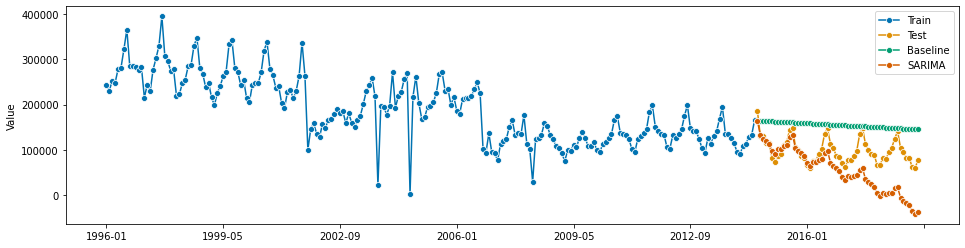

In [125]:
sarima_model_cal = AutoARIMA(sp=12, trace=True, maxiter=200)
sarima_model_cal.fit(y_train_cal)
sarima_preds_cal = sarima_model_cal.predict(y_test_cal.index)
plot_series(y_train_cal, y_test_cal, baseline_drift_preds_cal, sarima_preds_cal, 
            labels=['Train', 'Test', 'Baseline',"SARIMA"]);
print('Mean Absolute Percentage Error: ' + str(round(mean_absolute_percentage_error(y_test_cal, sarima_preds_cal),2)))
print('Mean Squared Error: ' + str(round(mean_squared_error(y_test_cal, sarima_preds_cal, squared=False),2)))

Mean Absolute Percentage Error: 0.29
Mean Squared Error: 32665.69


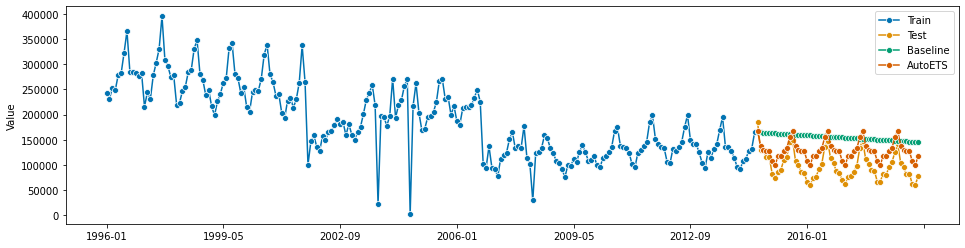

In [126]:
hw_model_cal = AutoETS(auto=True, sp=12, n_jobs=-1, trace=True)
hw_model_cal.fit(y_train_cal)
hw_model_preds_cal = hw_model_cal.predict(y_test_cal.index)
plot_series(y_train_cal, y_test_cal, baseline_drift_preds_cal, hw_model_preds_cal, 
            labels=['Train', 'Test', 'Baseline',"AutoETS"]);
print('Mean Absolute Percentage Error: ' + str(round(mean_absolute_percentage_error(y_test_cal, hw_model_preds_cal),2)))
print('Mean Squared Error: ' + str(round(mean_squared_error(y_test_cal, hw_model_preds_cal, squared=False),2)))

Mean Absolute Percentage Error: 0.21
Mean Squared Error: 22546.65


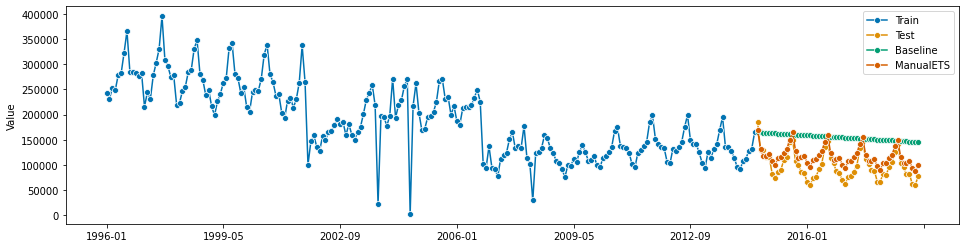

In [176]:
hw_manual_cal = AutoETS(error='add', trend='add', seasonal='mul', sp=12)
hw_manual_cal.fit(y_train_cal)
hw_manual_preds_cal = hw_manual_cal.predict(y_test_cal.index)
plot_series(y_train_cal, y_test_cal, baseline_drift_preds_cal, hw_manual_preds_cal, 
            labels=['Train', 'Test', 'Baseline', "ManualETS"]);
print('Mean Absolute Percentage Error: ' + str(round(mean_absolute_percentage_error(y_test_cal, hw_manual_preds_cal),2)))
print('Mean Squared Error: ' + str(round(mean_squared_error(y_test_cal, hw_manual_preds_cal, squared=False),2)))
plt.savefig('./visualizations/cal_bestmodel.png', transparent=True, bbox_inches = 'tight')

- This plot shows the best performing model with the Calais.

- This plot compared this models performance to that of the test set and the baseline model.

- This forecasting model uses a manual AutoETS estimator and returns a mean squared error around 22,546 and a mean absolute percentage error of 20%

Mean Absolute Percentage Error: 0.26
Mean Squared Error: 25329.17


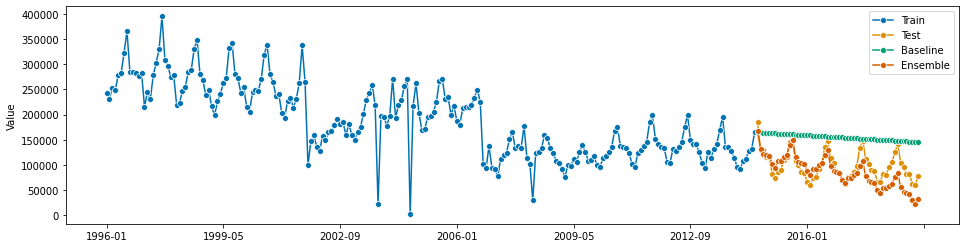

In [128]:
forecaster_cal = EnsembleForecaster([('sc', sarima_model_cal), ('hwc', hw_manual_cal)], n_jobs=-1)
forecaster_cal.fit(y_train_cal)
ensemble_preds_cal = forecaster_cal.predict(y_test_cal.index)
plot_series(y_train_cal, y_test_cal, baseline_drift_preds_cal, ensemble_preds_cal, 
            labels=['Train', 'Test', 'Baseline',"Ensemble"]);
print('Mean Absolute Percentage Error: ' + str(round(mean_absolute_percentage_error(y_test_cal, ensemble_preds_cal),2)))
print('Mean Squared Error: ' + str(round(mean_squared_error(y_test_cal, ensemble_preds_cal, squared=False),2)))

<br>
<br>
<br>
<br>

### 2.02 Timeseries Modeling for Buffalo-Niagara Falls, NY Ports of Entry.

Mean Absolute Percentage Error: 0.53
Mean Squared Error: 627452.52


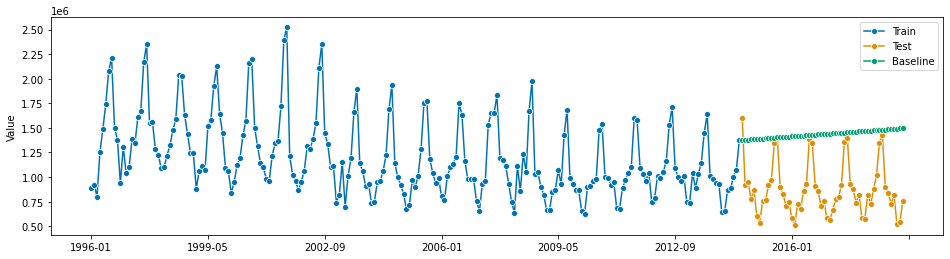

In [129]:
y_buf = df_buf['Value']
y_train_buf, y_test_buf = temporal_train_test_split(y_buf, test_size=.2)
baseline_drift_buf = NaiveForecaster(strategy='drift')
baseline_drift_buf.fit(y_train_buf)
baseline_drift_preds_buf = baseline_drift_buf.predict(y_test_buf.index)
plot_series(y_train_buf, y_test_buf, baseline_drift_preds_buf,labels=['Train', 'Test', 'Baseline']);
print('Mean Absolute Percentage Error: ' + str(round(mean_absolute_percentage_error(y_test_buf, baseline_drift_preds_buf),2)))
print('Mean Squared Error: ' + str(round(mean_squared_error(y_test_buf, baseline_drift_preds_buf, squared=False),2)))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6070.055, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6230.208, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6093.964, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6144.804, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6228.222, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6119.511, Time=0.30 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6074.265, Time=0.37 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=6071.321, Time=1.21 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=6071.086, Time=0.84 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6202.304, Time=0.13 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=6097.868, Time=0.87 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=6072.809, Time=0.77 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=6073.060, Time=1.58 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=6077.585, Time=0.43 sec
 ARIMA(2,1,1)(1,0,1

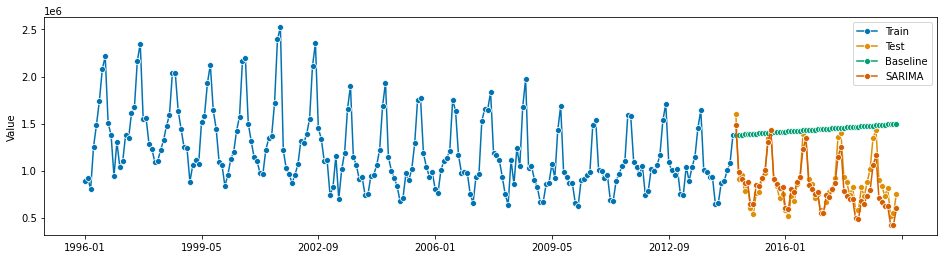

In [130]:
sarima_model_buf = AutoARIMA(sp=12, trace=True, maxiter=200)
sarima_model_buf.fit(y_train_buf)
sarima_preds_buf = sarima_model_buf.predict(y_test_buf.index)
plot_series(y_train_buf, y_test_buf, baseline_drift_preds_buf, sarima_preds_buf, 
            labels=['Train', 'Test', 'Baseline',"SARIMA"]);
print('Mean Absolute Percentage Error: ' + str(round(mean_absolute_percentage_error(y_test_buf, sarima_preds_buf),2)))
print('Mean Squared Error: ' + str(round(mean_squared_error(y_test_buf, sarima_preds_buf, squared=False),2)))

Mean Absolute Percentage Error: 0.1
Mean Squared Error: 98517.41


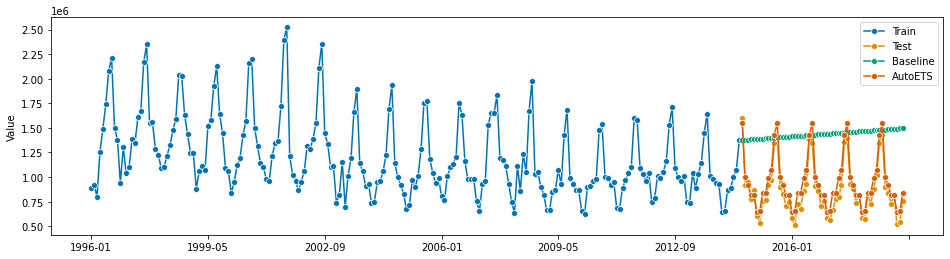

In [134]:
hw_model_buf = AutoETS(auto=True, sp=12, n_jobs=-1, trace=True)
hw_model_buf.fit(y_train_buf)
hw_model_preds_buf = hw_model_buf.predict(y_test_buf.index)
plot_series(y_train_buf, y_test_buf, baseline_drift_preds_buf, hw_model_preds_buf, 
            labels=['Train', 'Test', 'Baseline', "AutoETS"]);
print('Mean Absolute Percentage Error: ' + str(round(mean_absolute_percentage_error(y_test_buf, hw_model_preds_buf),2)))
print('Mean Squared Error: ' + str(round(mean_squared_error(y_test_buf, hw_model_preds_buf, squared=False),2)))

Mean Absolute Percentage Error: 0.06
Mean Squared Error: 60511.53


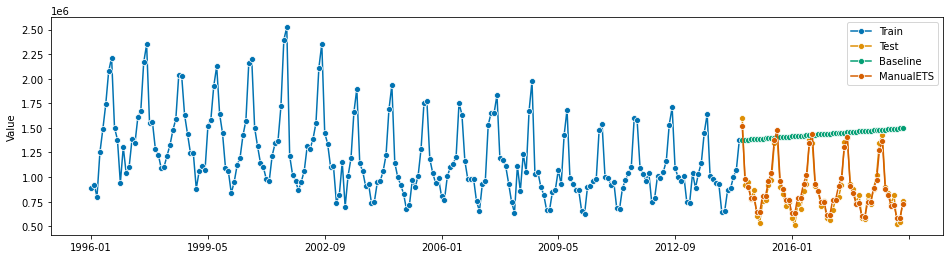

In [177]:
hw_manual_buf = AutoETS(error='add', trend='add', seasonal='mul', sp=12)
hw_manual_buf.fit(y_train_buf)
hw_manual_preds_buf = hw_manual_buf.predict(y_test_buf.index)
plot_series(y_train_buf, y_test_buf, baseline_drift_preds_buf, hw_manual_preds_buf, 
            labels=['Train', 'Test', 'Baseline', "ManualETS"]);
print('Mean Absolute Percentage Error: ' + str(round(mean_absolute_percentage_error(y_test_buf, hw_manual_preds_buf),2)))
print('Mean Squared Error: ' + str(round(mean_squared_error(y_test_buf, hw_manual_preds_buf, squared=False),2)))
plt.savefig('./visualizations/buf_bestmodel.png', transparent=True, bbox_inches = 'tight')

- This plot shows the best performing model with the Buffalo set.

- This plot compared this models performance to that of the test set and the baseline model.

- This forecasting model uses a manual AutoETS estimator and returns a mean squared error around 60,511 and a mean absolute percentage error of 6%

/opt/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/sktime_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertib

Mean Absolute Percentage Error: 0.08
Mean Squared Error: 76377.22


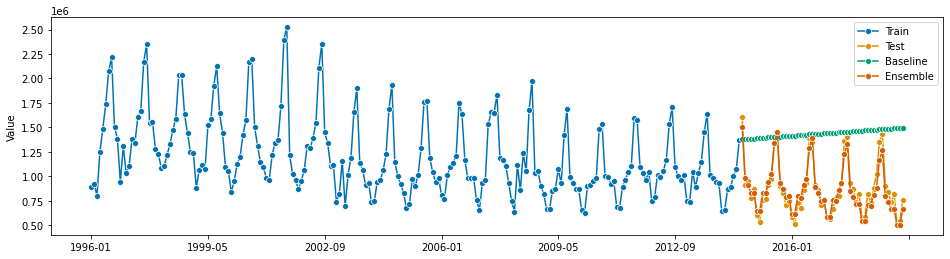

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5318.983, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5369.572, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5347.946, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5344.096, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5367.589, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5333.793, Time=0.43 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=5329.896, Time=0.33 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5343.596, Time=0.16 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=5328.546, Time=0.85 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=5322.943, Time=1.05 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=1.96 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=5317.615, Time=0.32 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept

In [136]:
forecaster_buf = EnsembleForecaster([('sb', sarima_model_buf), ('hwb', hw_manual_buf)], n_jobs=-1)
forecaster_buf.fit(y_train_buf)
ensemble_preds_buf = forecaster_buf.predict(y_test_buf.index)
plot_series(y_train_buf, y_test_buf, baseline_drift_preds_buf, ensemble_preds_buf, 
            labels=['Train', 'Test', 'Baseline',"Ensemble"]);
print('Mean Absolute Percentage Error: ' + str(round(mean_absolute_percentage_error(y_test_buf, ensemble_preds_buf),2)))
print('Mean Squared Error: ' + str(round(mean_squared_error(y_test_buf, ensemble_preds_buf, squared=False),2)))